1. How much does a typical consumer spend across various product categories?<br>
2. How frequently do Credit Card, Cash, and E-Wallet payments occur?
3. Which store (Branch) achieves the highest average sales and how does customer rating differ across branches?
4. How is quantity being purchased proportional to the total sales amount?
5. How does the average sales amount on weekends compare to that on weekdays?
6. What is the relationship between time-of-day segments (morning, afternoon, evening, night) and transaction sales amounts

Predictive Question:<br>
Which machine learning model most accurately predicts the total sales amount of a transaction using product characteristics, customer attributes, payment methods, quantity, unit price, and time-based features such as weekend status and time of day?

In [126]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [128]:
df=pd.read_csv('SuperMarket Analysis.csv')

In [129]:
df.head(5)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


In [130]:
df.describe()

,Unit price,Quantity,Tax 5%,Sales,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905e+00,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,6.131498e-14,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905e+00,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905e+00,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905e+00,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905e+00,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905e+00,49.650000,10.00000


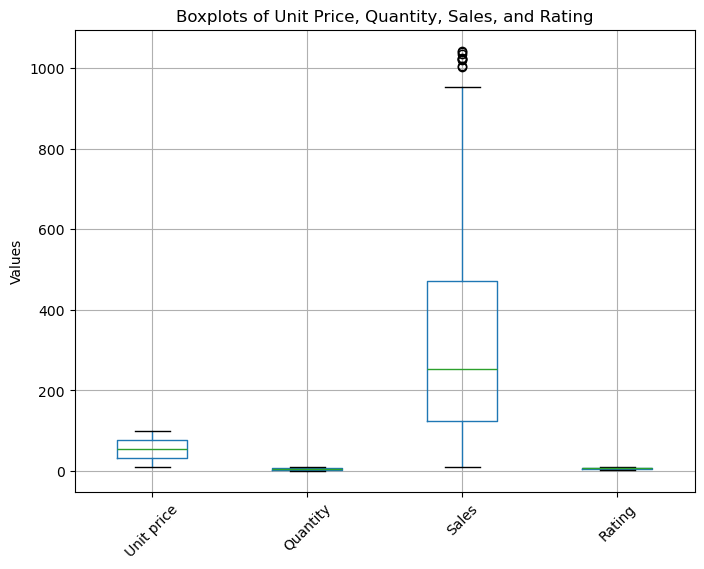

In [145]:

columns_to_plot = ['Unit price', 'Quantity', 'Sales', 'Rating']

# Create boxplots
plt.figure(figsize=(8,6))
df[columns_to_plot].boxplot()
plt.title('Boxplots of Unit Price, Quantity, Sales, and Rating')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()


In [147]:

Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_transactions = df[df['Sales'] > upper_bound]

outlier_transactions

,Invoice ID,Branch,City,CustomerType,Gender,ProductLine,Unit price,Quantity,Tax,Sales,...,Time,PaymentMethod,cogs,gross margin percentage,gross_income,Rating,Day_of_Week,Is_Weekend,Hour,Time_of_Day
166,234-65-2137,Giza,Naypyitaw,Normal,Male,Home and lifestyle,95.58,10,47.790,1003.590,...,2025-04-27 13:32:00,Cash,955.8,4.761905,47.790,4.8,Wednesday,0,13,Afternoon
167,687-47-8271,Alex,Yangon,Normal,Male,Fashion accessories,98.98,10,49.490,1039.290,...,2025-04-27 16:20:00,Credit card,989.8,4.761905,49.490,8.7,Friday,0,16,Afternoon
350,860-79-0874,Giza,Naypyitaw,Member,Female,Fashion accessories,99.30,10,49.650,1042.650,...,2025-04-27 14:53:00,Credit card,993.0,4.761905,49.650,6.6,Friday,0,14,Afternoon
357,554-42-2417,Giza,Naypyitaw,Normal,Female,Sports and travel,95.44,10,47.720,1002.120,...,2025-04-27 13:45:00,Cash,954.4,4.761905,47.720,5.2,Wednesday,0,13,Afternoon
422,271-88-8734,Giza,Naypyitaw,Member,Female,Fashion accessories,97.21,10,48.605,1020.705,...,2025-04-27 13:00:00,Credit card,972.1,4.761905,48.605,8.7,Friday,0,13,Afternoon
557,283-26-5248,Giza,Naypyitaw,Member,Female,Food and beverages,98.52,10,49.260,1034.460,...,2025-04-27 20:23:00,Ewallet,985.2,4.761905,49.260,4.5,Wednesday,0,20,Evening
699,751-41-9720,Giza,Naypyitaw,Normal,Male,Home and lifestyle,97.50,10,48.750,1023.750,...,2025-04-27 16:18:00,Ewallet,975.0,4.761905,48.750,8.0,Saturday,1,16,Afternoon
792,744-16-7898,Cairo,Mandalay,Normal,Female,Home and lifestyle,97.37,10,48.685,1022.385,...,2025-04-27 13:48:00,Credit card,973.7,4.761905,48.685,4.9,Tuesday,0,13,Afternoon
996,303-96-2227,Cairo,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.690,1022.490,...,2025-04-27 17:16:00,Ewallet,973.8,4.761905,48.690,4.4,Saturday,1,17,Evening


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Sales                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [132]:
df = df.rename(columns={
    'Product line': 'ProductLine',
    'Customer type': 'CustomerType',
    'Payment': 'PaymentMethod',
    'Tax 5%' : 'Tax',
    'gross income' : 'gross_income'
})

In [133]:
df.duplicated().sum()

0

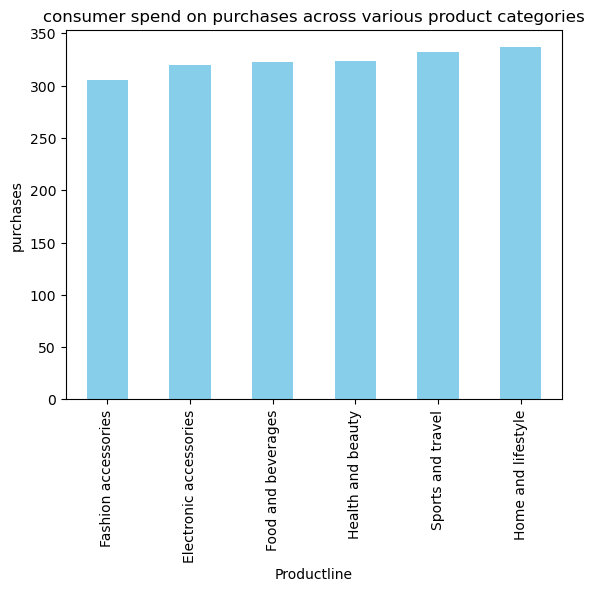

In [134]:
#1.How much does a typical consumer spend across various product categories?

group_data = df.groupby(['ProductLine'])['Sales'].mean().sort_values()
group_data.plot(kind='bar',color='skyblue')
plt.title('consumer spend on purchases across various product categories')
plt.xlabel('Productline')
plt.ylabel('purchases')
plt.show()

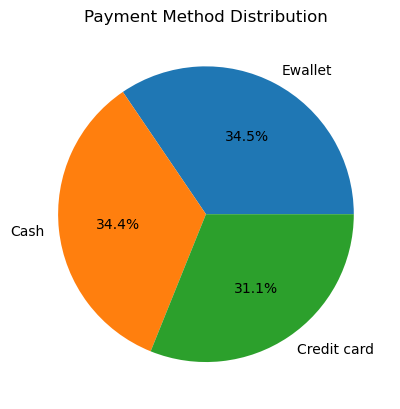

In [135]:
#2.How frequently do Credit Card, Cash, and E-Wallet payments occur?
payment_freq=df['PaymentMethod'].value_counts()
payment_freq.plot(kind='pie', autopct='%1.1f%%', title='Payment Method Distribution')
plt.ylabel('') 
plt.show()

Branch
Alex     312.354031
Cairo    319.872506
Giza     337.099715
Name: Sales, dtype: float64
Branch
Alex     7.027059
Cairo    6.818072
Giza     7.072866
Name: Rating, dtype: float64


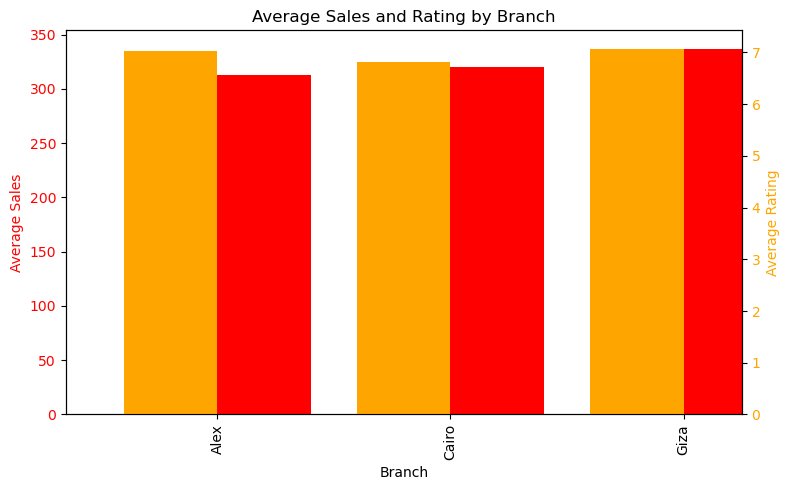

In [136]:
#3.Which store (Branch) achieves the highest average sales and how does customer rating differ across branches?
# Average sales per branch
avg_sales_branch = df.groupby('Branch')['Sales'].mean()

# Average rating per branch
avg_rating_branch = df.groupby('Branch')['Rating'].mean()

print(avg_sales_branch)
print(avg_rating_branch)

fig, ax1 = plt.subplots(figsize=(8,5))

# First bar: Average Sales
avg_sales_branch.plot(kind='bar', color='red', ax=ax1, position=0, width=0.4)
ax1.set_ylabel('Average Sales', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Second y-axis for Average Rating
ax2 = ax1.twinx()
avg_rating_branch.plot(kind='bar', color='orange', ax=ax2, position=1, width=0.4)
ax2.set_ylabel('Average Rating', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Average Sales and Rating by Branch')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Correlation between Quantity and Sales: 0.71


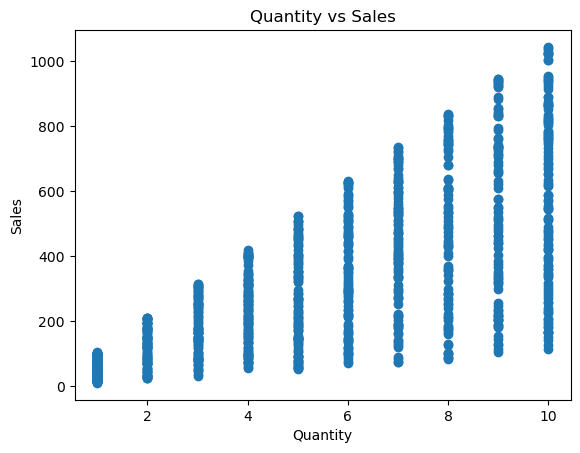

In [137]:
#4.How is quantity being purchased proportional to the total sales amount?
# Correlation between Quantity and Sales
quantity_sales_corr = df[['Quantity', 'Sales']].corr().iloc[0,1]

print(f"Correlation between Quantity and Sales: {quantity_sales_corr:.2f}")

plt.scatter(df['Quantity'], df['Sales'])
plt.xlabel('Quantity')
plt.ylabel('Sales')
plt.title('Quantity vs Sales')
plt.show()



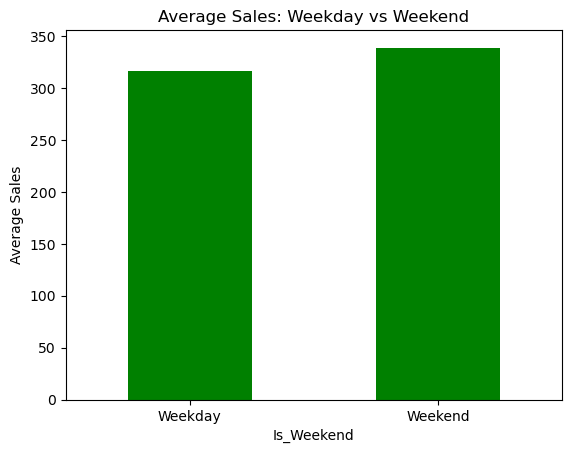

In [138]:
#5.How does the average sales amount on weekends compare to that on weekdays?
df['Date']=pd.to_datetime(df['Date'])

df['Day_of_Week'] = (df['Date']).dt.day_name()
df['Is_Weekend'] = df['Day_of_Week'].isin(['Saturday', 'Sunday']).astype(int)
weekend_sales = df.groupby('Is_Weekend')['Sales'].mean()

weekend_sales.plot(kind='bar',color = 'green')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
plt.ylabel('Average Sales')
plt.title('Average Sales: Weekday vs Weekend')
plt.show()

In [139]:
#6.What is the relationship between time-of-day segments (morning, afternoon, evening, night) and transaction sales amounts
df['Time'] = pd.to_datetime(df['Time'])
df['Hour']=df['Time'].dt.hour
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Time_of_Day'] = df['Hour'].apply(time_of_day)

df['Time_of_Day'].value_counts()

Time_of_sales = df.groupby('Time_of_Day')['Sales'].mean().sort_values()

print(Time_of_sales)

Time_of_Day
Evening      318.717177
Morning      323.553982
Afternoon    326.042600
Name: Sales, dtype: float64


C:\Users\kk1003\AppData\Local\Temp\ipykernel_3600\3084969166.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


Which machine learning model most accurately predicts the total sales amount of a transaction using product characteristics, customer attributes, payment methods, quantity, unit price, and time-based features such as weekend status and time of day?

In [140]:
# Features and Target
X = df[['ProductLine', 'CustomerType', 'PaymentMethod', 'Quantity', 'Unit price', 'Is_Weekend', 'Time_of_Day']]
y = df['Sales']

# One-hot encoding (convert categories into numbers)
X = pd.get_dummies(X, drop_first=True)
X=X.astype(int)
X.head()


,Quantity,Unit price,Is_Weekend,ProductLine_Fashion accessories,ProductLine_Food and beverages,ProductLine_Health and beauty,ProductLine_Home and lifestyle,ProductLine_Sports and travel,CustomerType_Normal,PaymentMethod_Credit card,PaymentMethod_Ewallet,Time_of_Day_Evening,Time_of_Day_Morning
0,7,74,1,0,0,1,0,0,0,0,1,0,0
1,5,15,0,0,0,0,0,0,1,0,0,0,1
2,7,46,1,0,0,0,1,0,1,1,0,0,0
3,8,58,1,0,0,1,0,0,0,0,1,1,0
4,7,86,0,0,0,0,0,1,0,0,1,0,1


C:\Users\kk1003\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


linear regression RMSE: 79.69
linear regression R² Score: 0.90


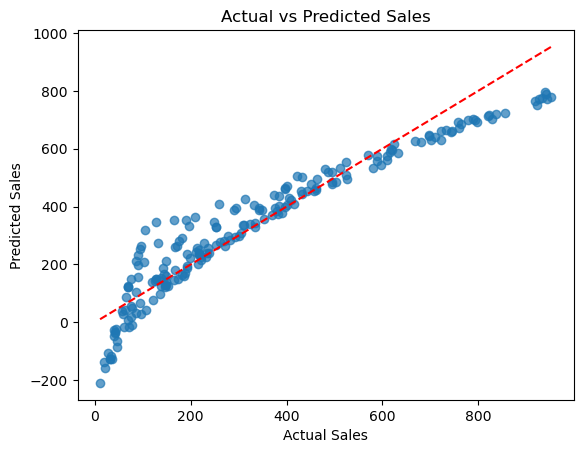

In [141]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#linearregression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'linear regression RMSE: {rmse:.2f}')
print(f'linear regression R² Score: {r2:.2f}')

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.show()


C:\Users\kk1003\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest RMSE: 8.05
Random Forest R²: 1.00


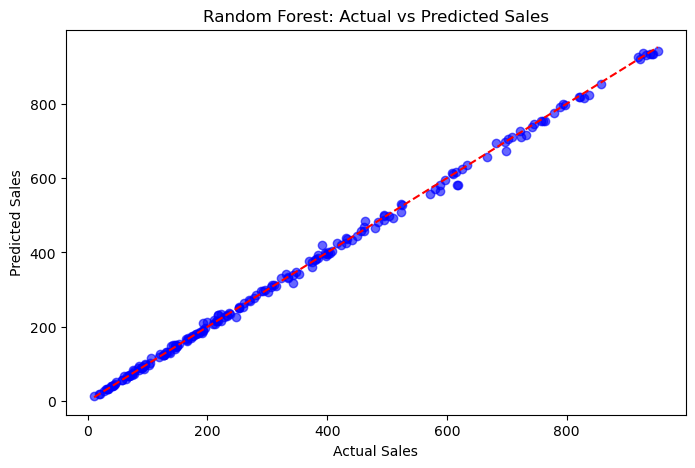

In [142]:

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f'Random Forest RMSE: {rf_rmse:.2f}')
print(f'Random Forest R²: {rf_r2:.2f}')


plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Random Forest: Actual vs Predicted Sales')
plt.show()


C:\Users\kk1003\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost RMSE: 8.06
XGBoost R²: 1.00


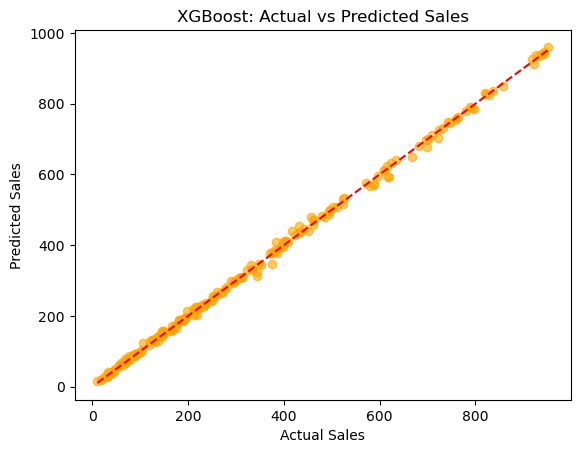

In [143]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f'XGBoost RMSE: {xgb_rmse:.2f}')
print(f'XGBoost R²: {xgb_r2:.2f}')

plt.scatter(y_test, y_pred_xgb, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('XGBoost: Actual vs Predicted Sales')
plt.show()